In [ ]:
#%%

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from algorithmos import Hansen_Algorithm

In [ ]:
#%%

def new_blade_geometry(r_is, chords, pitch, tc_ratios,
                            r_first, r_last, num_sections=10):
    """
    Δημιουργεί νέο διάνυσμα ακτινικών θέσεων r_new με μήκος num_sections
    (δηλ. num_sections σημεία) γραμμικά κατανεμημένα από r_first μέχρι r_last.
    Στη συνέχεια υπολογίζει με γραμμική παρεμβολή τις τιμές chord, pitch, tc_ratio
    στα r_new.
    """
    # ορίζουμε τα νέα ακτινικά σημεία
    r_new = np.linspace(r_first, r_last, num_sections)

    # φτιάχνουμε τις συναρτήσεις παρεμβολής από τα αρχικά δεδομένα
    chord_interp = interp1d(r_is, chords, kind='linear')
    pitch_interp = interp1d(r_is, pitch, kind='linear')
    tc_interp = interp1d(r_is, tc_ratios, kind='linear')
    
    # υπολογίζουμε τις νέες τιμές
    chords_new = chord_interp(r_new)
    pitch_new = pitch_interp(r_new)
    tc_new = tc_interp(r_new)

    return r_new, chords_new, pitch_new, tc_new

In [ ]:
#%%

class Hansen_Algorithm_for_DTU_geometry(Hansen_Algorithm): # Νέα κλάση για τη γεωμετρία του πτερυγίου (DTU airfoil)
    def __init__(self, wind_speed_V0, rotation_speed, blade_geom_file_2,
                 B=3, air_density=1.225, csv_data_file_DTU='csv_data_file_DTU.csv'):
        with open(blade_geom_file_2, 'r') as f:
            blade_geom_file_2 = json.load(f)
        r_is_original = blade_geom_file_2["r_is"]
        chords_original = blade_geom_file_2["chords"]
        pitch_original = blade_geom_file_2["pitch"]
        tc_ratios_original = blade_geom_file_2["tc_ratios"]
        no_sections = blade_geom_file_2["no_sections"]

        r_first = r_is_original[0] 
        r_last = 89.166             

        # Δημιουργούμε 10 σημεία με γραμμική παρεμβολή
        r_new, chords_new, pitch_new, tc_new = new_blade_geometry(
            r_is_original,
            chords_original,
            pitch_original,
            tc_ratios_original,
            r_first,
            r_last,
            num_sections = 10
        )

        self.r_is = r_new
        self.chords = chords_new
        self.pitch = pitch_new
        self.tc_ratios = tc_new
        self.no_sections = len(r_new)
        R_new = 89.166
        
        super().__init__(wind_speed_V0, R_new, rotation_speed,
                         B, air_density,
                         airfoil_type="DTU",
                         csv_data_file=csv_data_file_DTU)
        
    def DTU_blade_calculation(self):
        results_list_for_DTU_airfoil = [] # η λίστα που θα αποθηκεύει τα αποτελέσματα για το κάθε τμήμα του πτερυγίου
        total_power = 0 # αρχικά η συνολική ισχύς είναι 0
        total_torque = 0 # αρχικά η συνολική ροπή είναι 0
        total_thrust = 0 # αρχικά η συνολική ώση είναι 0
        for i in range(self.no_sections):
            r = self.r_is[i]
            chord = self.chords[i]
            pitch_angle = self.pitch[i]
            tc_ratio = self.tc_ratios[i]
            twist = 0 
            try:
                results_for_DTU_airfoil = self.segment_calculation(r=r, chord=chord, pitch_angle=pitch_angle, twist=twist, tc_ratio=tc_ratio)
                # Η εφαπτομενική συνιστώσα είναι αυτή που παράγει τη ροπή
                dr = (self.r_is[i+1] - self.r_is[i]) if i < self.no_sections - 1 else (self.R - r)
                flow_angle, a, a_p = results_for_DTU_airfoil["flow_angle (rads)"], results_for_DTU_airfoil["a"], results_for_DTU_airfoil["a_p"]
                Cn = results_for_DTU_airfoil["Cn"]
                Ct = results_for_DTU_airfoil["Ct"]
                dM = (
                    0.5 * self.air_density * self.B *
                    ((self.wind_speed_V0 * (1 - a) * self.rotation_speed * r * (1 + a_p)) /
                     (np.abs(np.sin(flow_angle)) * np.abs(np.cos(flow_angle))) *
                    chord * Ct * r * dr
                ))
                dT = ( 
                    0.5 * self.air_density * self.B * 
                ((self.wind_speed_V0**2 * (1 - a)**2) / np.abs(np.sin(flow_angle)**2)) * chord * Cn * dr 
                )
                # dM = r * self.B * results["pt"] * dr
                # dM = 4 * np.pi * self.air_density * self.wind_speed_V0 * self.rotation_speed * (1 - a) * a_p * r**3 * dr
                power = self.rotation_speed * dM
                total_power += power # Συνολική ισχύς όλου του ρότορα 
                total_torque += dM # Συνολική ροπή του ρότορα
                total_thrust += dT # Συνολική ώση του ρότορα
                # dP = 0.5 * self.air_density * 2 * np.pi * self.wind_speed_V0**3 * Ct * r * dr
                # total_power += dP
                results_for_DTU_airfoil["t/c ratio"] = tc_ratio
                results_for_DTU_airfoil["dT (Ν)"] = (dT/3) # Διαιρώ δια 3 καθώς η συγκεκριμένη τιμή αφορά και τα τρία πτερύγια
                results_for_DTU_airfoil["dM (Nm)"] = (dM/3) # Διαιρώ δια 3 καθώς η συγκεκριμένη τιμή αφορά και τα τρία πτερύγια
                results_for_DTU_airfoil["Power (Watt)"] = ((power)/3) # Διαιρώ δια 3 καθώς η συγκεκριμένη τιμή αφορά και τα τρία πτερύγια
                results_list_for_DTU_airfoil.append(results_for_DTU_airfoil)
            except Exception as e:
                print(f"Section {i} at radius {r}: {e}")
        return results_list_for_DTU_airfoil, total_power, total_torque, total_thrust
    
    def calculation_of_coefficient_of_power_cp_for_DTU(self, total_power):
        swept_area = np.pi * self.R**2 # επιφάνεια σάρωσης
        wind_power = 0.5 * self.air_density * swept_area * self.wind_speed_V0**3
        return total_power / wind_power
    
    def calculation_of_coefficient_of_thrust_CT_for_DTU(self, total_thrust):
        swept_area = np.pi * self.R**2 # επιφάνεια σάρωσης
        wind_force = 0.5 * self.air_density * swept_area * self.wind_speed_V0**2
        return total_thrust / wind_force

/Users/konstantinosacheimastos/Desktop/GITHUB/algorithmos.py:36: RuntimeWarning: divide by zero encountered in scalar divide
  return np.arctan(v_axial / v_tangential)


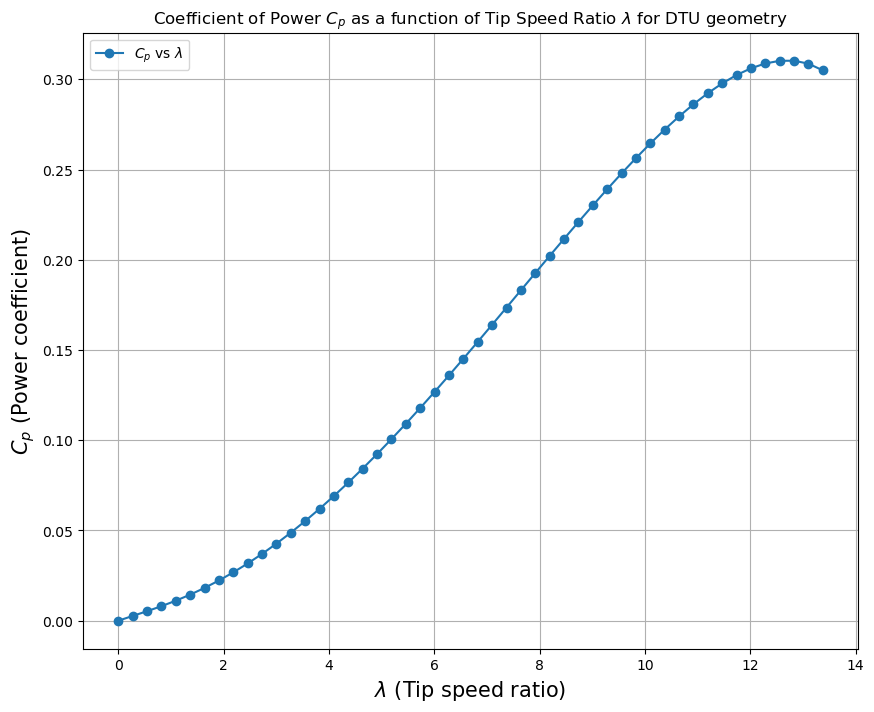

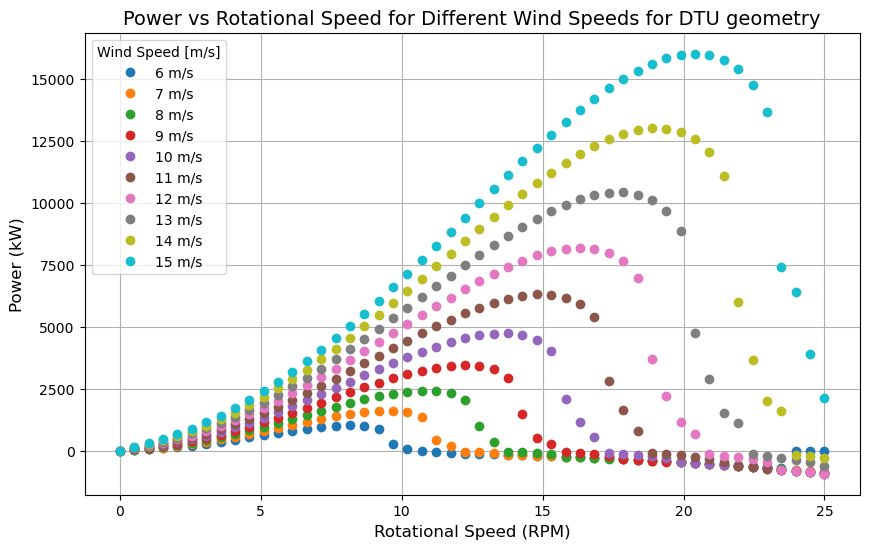

     r_i (m)  chord (m)  pitch_angle (degrees)  twist (degrees)         a  \
0   2.800000   5.380000              14.500000                0  0.132748   
1  12.396222   5.550676              13.984151                0  0.093739   
2  21.992444   6.133718               9.475086                0  0.253363   
3  31.588667   6.032624               6.575359                0  1.000000   
4  41.184889   5.446945               4.745151                0  1.000000   
5  50.781111   4.666353               2.810051                0  1.000000   
6  60.377333   3.845289               0.865571                0  1.000000   
7  69.973556   3.068598              -0.798499                0  1.000000   
8  79.569778   2.371146              -2.199142                0  0.400921   
9  89.166000   0.600000              -3.428000                0  0.074551   

        a_p  flow_angle (rads)  flow angle (degrees)  angle_of_attack (rads)  \
0 -0.132748       1.116236e+00          6.395560e+01                0.86

In [ ]:
#%%

if __name__ == "__main__":
    blade_geom_file_2 = "blade_geom_file_2.json"
    hansen_DTU = Hansen_Algorithm_for_DTU_geometry(
        wind_speed_V0=10,
        rotation_speed=0,
        blade_geom_file_2=blade_geom_file_2,
        B=3,
        air_density=1.225
    )
    
    # ΔΙΑΓΡΑΜΜΑ Power Coefficient Cp - Tip Speed Ratio λ for DTU geometry
    rotation_speed_values = np.linspace(0, 1.5, 50)
    lambda_values = []
    cp_values = []
    
    for rotational_speed in rotation_speed_values:
        hansen_DTU.rotation_speed = rotational_speed
        λ = (rotational_speed * hansen_DTU.R) / hansen_DTU.wind_speed_V0
        lambda_values.append(λ)
        
        results_for_Naca_geometry, total_power, total_torque, total_thrust = hansen_DTU.DTU_blade_calculation()
        cp = hansen_DTU.calculation_of_coefficient_of_power_cp_for_DTU(total_power)
        cp_values.append(cp)
        
    plt.figure(figsize=(10, 8))
    plt.plot(lambda_values, cp_values, 'o-', label="$C_p$ vs $λ$")
    plt.xlabel("$λ$ (Tip speed ratio)", fontsize=15)
    plt.ylabel("$C_p$ (Power coefficient)", fontsize=15)
    plt.title("Coefficient of Power $C_p$ as a function of Tip Speed Ratio $λ$ for DTU geometry")
    plt.legend()
    plt.grid()
    plt.show()
    
    # ΔΙΑΓΡΑΜΜΑ ταχύτητας n(rpm) - ισχύος P(kWatt) for DTU geometry
    rpm_values = np.linspace(0, 25, 50) # Τιμές RPM
    wind_speed_values = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15] # Ταχύτητες ανέμου

    plt.figure(figsize=(10, 6))

    for V0 in wind_speed_values:
        power_values = []
        for n in rpm_values:
            ω = (2 * np.pi * n) / 60 # Γωνιακή ταχύτητα σε rad/s
            λ = (ω * hansen_DTU.R) / V0 # Tip Speed Ratio
            hansen_DTU.wind_speed_V0 = V0
            hansen_DTU.rotation_speed = ω
            results_for_DTU_geometry, total_power, total_torque, total_thrust = hansen_DTU.DTU_blade_calculation()
            power_values.append(total_power*1e-3) # Ισχύς σε kW
            
        plt.plot(rpm_values, power_values,'o', label=f"{V0} m/s", )

    plt.xlabel("Rotational Speed (RPM)", fontsize=12)
    plt.ylabel("Power (kW)", fontsize=12)
    plt.title("Power vs Rotational Speed for Different Wind Speeds for DTU geometry", fontsize=14)
    plt.legend(title="Wind Speed [m/s]")
    plt.grid()
    plt.show()
    
    df_DTU_results = pd.DataFrame(results_for_DTU_geometry)
    print(df_DTU_results)
    
    print(f"Η συνολική ισχύς της ανεμογεννήτριας είναι {total_power:.2f} Watt")
    print(f"H συνολική ροπή της ανεμογεννήτριας είναι {total_torque:.2f} Nm")
    print(f"H συνολική ώση της ανεμογεννήτριας είναι {total_thrust:.2f} N")
    # df_DTU_results.to_csv("output_tab.csv", sep="\t", index=False)